# 🏭 니켈 가격 예측 - 고급 기법 추가 실험

---

## 개요

**기준선**: sparta2.ipynb에서 발견한 Hybrid(Naive 80% + GB 20%) = RMSE 406.80

**목표**: 기준선 대비 추가 성능 개선 가능성 탐색

---

## 실험 목록

| 실험 | 기법 | 설명 |
|------|------|------|
| 1 | **LSTM** | Long Short-Term Memory 시계열 딥러닝 |
| 2 | **ARIMA** | AutoRegressive Integrated Moving Average |
| 3 | **Quantile Regression** | 예측 불확실성 구간 추정 |
| 4 | **Multi-Lag Features** | 다중 시차 피처 엔지니어링 |

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

# 설정
CONFIG = {
    'data_file': 'data_weekly_260120.csv',
    'target_col': 'Com_LME_Ni_Cash',
    'val_start': '2025-08-04',
    'val_end': '2025-10-20',
    'test_start': '2025-10-27',
    'test_end': '2026-01-12',
    'random_seed': 42
}
np.random.seed(CONFIG['random_seed'])

print('='*70)
print('🏭 니켈 가격 예측 - 고급 기법 추가 실험')
print('='*70)
print('기준선: Hybrid(Naive*0.8 + GB*0.2) RMSE = 406.80')
print('='*70)

🏭 니켈 가격 예측 - 고급 기법 추가 실험
기준선: Hybrid(Naive*0.8 + GB*0.2) RMSE = 406.80


In [2]:
# 데이터 로드 및 전처리
df_raw = pd.read_csv(CONFIG['data_file'])
df_raw['dt'] = pd.to_datetime(df_raw['dt'])
df_raw = df_raw.set_index('dt').sort_index()
target_col = CONFIG['target_col']

def filter_cols(columns):
    metals = ['Gold', 'Silver', 'Iron', 'Steel', 'Copper', 'Aluminum', 'Zinc', 'Nickel', 'Lead', 'Tin', 'Uranium']
    filtered = [target_col]
    for col in columns:
        if any(x in col for x in ['Idx_', 'Bonds_', 'EX_']):
            filtered.append(col)
        elif 'Com_LME' in col and 'Index' not in col:
            filtered.append(col)
        elif any(m in col for m in metals):
            filtered.append(col)
    return sorted(list(set(filtered)))

df = df_raw[filter_cols(df_raw.columns)].copy().ffill().dropna()
y = df[target_col]
X = df.drop(columns=[target_col]).shift(1)
X = X.ffill().dropna(axis=1, how='all')
valid_idx = X.dropna().index.intersection(y.dropna().index)
X, y = X.loc[valid_idx], y.loc[valid_idx]

train_mask = X.index < CONFIG['val_start']
val_mask = (X.index >= CONFIG['val_start']) & (X.index <= CONFIG['val_end'])
test_mask = (X.index >= CONFIG['test_start']) & (X.index <= CONFIG['test_end'])

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

train_mean = X_train.mean()
X_train = X_train.fillna(train_mean)
X_val = X_val.fillna(train_mean)
X_test = X_test.fillna(train_mean)

print(f'데이터: Train {len(X_train)} | Val {len(X_val)} | Test {len(X_test)}')

데이터: Train 643 | Val 12 | Test 12


In [3]:
# 기준선 재확인: Naive Drift + GB Hybrid
def calc_naive_drift(y_series, indices):
    preds = []
    for idx in indices:
        prev = y_series.shift(1).loc[idx]
        prev2 = y_series.shift(2).loc[idx]
        preds.append(prev + (prev - prev2))
    return np.array(preds)

gb_base = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42)
gb_base.fit(X_train, y_train)

naive_test = calc_naive_drift(y, y_test.index)
gb_test = gb_base.predict(X_test)
baseline_pred = 0.8 * naive_test + 0.2 * gb_test

BASELINE_RMSE = np.sqrt(mean_squared_error(y_test, baseline_pred))
print(f'🎯 Baseline (Hybrid 0.8:0.2) Test RMSE: {BASELINE_RMSE:.2f}')

🎯 Baseline (Hybrid 0.8:0.2) Test RMSE: 419.14


---

## 실험 1: LSTM (Long Short-Term Memory)

### 모델 설명
- **LSTM**: 순환 신경망(RNN)의 변형으로, 장기 의존성을 학습할 수 있는 딥러닝 모델
- **작동 원리**: Cell State를 통해 과거 정보를 선택적으로 기억/망각
- **시계열 적합성**: 순차적 패턴 학습에 강점

### 구현
- Look-back window: 4주 (과거 4주 데이터로 다음 주 예측)
- 구조: LSTM(50) → Dense(1)
- 학습: 100 epochs with early stopping

In [4]:
print('='*70)
print('[실험 1] LSTM - 시계열 딥러닝')
print('='*70)

try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    
    # 데이터 준비 (LSTM용 3D 형태)
    look_back = 4
    
    def create_sequences(data, look_back):
        X_seq, y_seq = [], []
        for i in range(look_back, len(data)):
            X_seq.append(data[i-look_back:i])
            y_seq.append(data[i])
        return np.array(X_seq), np.array(y_seq)
    
    # 전체 타겟 시계열 사용
    scaler = MinMaxScaler()
    y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()
    
    # Train/Val/Test 분할 인덱스
    train_end_idx = len(y_train) + look_back
    val_end_idx = train_end_idx + len(y_val)
    
    X_seq, y_seq = create_sequences(y_scaled, look_back)
    
    # 분할
    X_train_lstm = X_seq[:len(y_train)]
    y_train_lstm = y_seq[:len(y_train)]
    X_test_lstm = X_seq[-(len(y_test)):]
    y_test_lstm = y_seq[-(len(y_test)):]
    
    # LSTM 모델
    model_lstm = Sequential([
        LSTM(50, activation='relu', input_shape=(look_back, 1)),
        Dropout(0.2),
        Dense(1)
    ])
    model_lstm.compile(optimizer='adam', loss='mse')
    
    early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    
    print('LSTM 학습 중...')
    history = model_lstm.fit(
        X_train_lstm.reshape(-1, look_back, 1), 
        y_train_lstm,
        epochs=100, 
        batch_size=32, 
        verbose=0,
        callbacks=[early_stop]
    )
    
    # 예측
    lstm_pred_scaled = model_lstm.predict(X_test_lstm.reshape(-1, look_back, 1), verbose=0)
    lstm_pred = scaler.inverse_transform(lstm_pred_scaled).flatten()
    
    lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_pred))
    print(f'\n📊 LSTM Test RMSE: {lstm_rmse:.2f}')
    print(f'   기준선 대비: {BASELINE_RMSE - lstm_rmse:+.2f}')
    
    # LSTM + Naive Hybrid
    for alpha in [0.7, 0.8, 0.9]:
        hybrid = alpha * naive_test + (1-alpha) * lstm_pred
        rmse = np.sqrt(mean_squared_error(y_test, hybrid))
        print(f'   Naive*{alpha} + LSTM*{1-alpha:.1f}: RMSE = {rmse:.2f} ({BASELINE_RMSE - rmse:+.2f})')
    
    LSTM_AVAILABLE = True
    
except ImportError:
    print('⚠️ TensorFlow/Keras가 설치되지 않았습니다.')
    print('   pip install tensorflow 로 설치 가능')
    LSTM_AVAILABLE = False
    lstm_rmse = None

[실험 1] LSTM - 시계열 딥러닝
⚠️ TensorFlow/Keras가 설치되지 않았습니다.
   pip install tensorflow 로 설치 가능


---

## 실험 2: ARIMA (AutoRegressive Integrated Moving Average)

### 모델 설명
- **AR (AutoRegressive)**: 과거 값들의 선형 조합으로 예측
- **I (Integrated)**: 차분(differencing)으로 비정상 시계열을 정상화
- **MA (Moving Average)**: 과거 예측 오차들의 선형 조합

### 파라미터
- p: AR 차수 (과거 몇 개 값 사용)
- d: 차분 횟수
- q: MA 차수 (과거 몇 개 오차 사용)

In [5]:
print('='*70)
print('[실험 2] ARIMA - 전통 통계 시계열 모델')
print('='*70)

try:
    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tsa.stattools import adfuller
    
    # 정상성 검정
    adf_result = adfuller(y_train)
    print(f'ADF 검정 p-value: {adf_result[1]:.4f}')
    print(f'정상성: {"Yes" if adf_result[1] < 0.05 else "No (차분 필요)"}')
    
    # ARIMA 모델 (간단한 파라미터 조합 테스트)
    best_aic = float('inf')
    best_order = None
    
    print('\nARIMA 파라미터 탐색 중...')
    for p in [1, 2, 3]:
        for d in [0, 1]:
            for q in [0, 1, 2]:
                try:
                    model = ARIMA(y_train, order=(p, d, q))
                    fitted = model.fit()
                    if fitted.aic < best_aic:
                        best_aic = fitted.aic
                        best_order = (p, d, q)
                except:
                    continue
    
    print(f'\n최적 ARIMA 파라미터: {best_order} (AIC: {best_aic:.2f})')
    
    # 최적 모델로 예측
    model_arima = ARIMA(y_train, order=best_order)
    fitted_arima = model_arima.fit()
    
    # Multi-step ahead forecast
    forecast = fitted_arima.forecast(steps=len(y_test))
    arima_pred = forecast.values
    
    arima_rmse = np.sqrt(mean_squared_error(y_test, arima_pred))
    print(f'\n📊 ARIMA Test RMSE: {arima_rmse:.2f}')
    print(f'   기준선 대비: {BASELINE_RMSE - arima_rmse:+.2f}')
    
    # ARIMA + Naive Hybrid
    for alpha in [0.7, 0.8, 0.9]:
        hybrid = alpha * naive_test + (1-alpha) * arima_pred
        rmse = np.sqrt(mean_squared_error(y_test, hybrid))
        print(f'   Naive*{alpha} + ARIMA*{1-alpha:.1f}: RMSE = {rmse:.2f} ({BASELINE_RMSE - rmse:+.2f})')
    
    ARIMA_AVAILABLE = True
    
except ImportError:
    print('⚠️ statsmodels가 설치되지 않았습니다.')
    print('   pip install statsmodels 로 설치 가능')
    ARIMA_AVAILABLE = False
    arima_rmse = None

[실험 2] ARIMA - 전통 통계 시계열 모델
ADF 검정 p-value: 0.4274
정상성: No (차분 필요)

ARIMA 파라미터 탐색 중...


/opt/anaconda3/envs/ml/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/ml/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/ml/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/ml/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/ml/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency informatio


최적 ARIMA 파라미터: (3, 1, 2) (AIC: 10108.50)


/opt/anaconda3/envs/ml/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/ml/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/ml/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)



📊 ARIMA Test RMSE: 1315.97
   기준선 대비: -896.84
   Naive*0.7 + ARIMA*0.3: RMSE = 459.59 (-40.46)
   Naive*0.8 + ARIMA*0.2: RMSE = 416.01 (+3.12)
   Naive*0.9 + ARIMA*0.1: RMSE = 423.87 (-4.74)


---

## 실험 3: Quantile Regression (예측 불확실성)

### 모델 설명
- **목적**: 점 예측이 아닌 **예측 구간** 제공 (상한/하한)
- **방법**: 서로 다른 분위수(10%, 50%, 90%)에 대해 별도 모델 학습
- **장점**: 예측의 불확실성 정량화 가능

In [6]:
print('='*70)
print('[실험 3] Quantile Regression - 예측 불확실성')
print('='*70)

from sklearn.ensemble import GradientBoostingRegressor

quantiles = [0.1, 0.5, 0.9]
quantile_preds = {}

for q in quantiles:
    model_q = GradientBoostingRegressor(
        n_estimators=500, 
        learning_rate=0.05, 
        max_depth=5,
        loss='quantile',
        alpha=q,
        random_state=42
    )
    model_q.fit(X_train, y_train)
    quantile_preds[q] = model_q.predict(X_test)

# 50% 분위수 (중앙값) 성능
median_rmse = np.sqrt(mean_squared_error(y_test, quantile_preds[0.5]))
print(f'\n📊 Quantile(50%) Test RMSE: {median_rmse:.2f}')
print(f'   기준선 대비: {BASELINE_RMSE - median_rmse:+.2f}')

# 예측 구간 커버리지
y_test_arr = y_test.values
coverage = np.mean((y_test_arr >= quantile_preds[0.1]) & (y_test_arr <= quantile_preds[0.9]))
print(f'\n📊 80% 예측 구간 커버리지: {coverage*100:.1f}%')
print(f'   예측 구간 평균 폭: {np.mean(quantile_preds[0.9] - quantile_preds[0.1]):.2f}')

# Quantile + Naive Hybrid
print('\nHybrid 조합:')
for alpha in [0.7, 0.8, 0.9]:
    hybrid = alpha * naive_test + (1-alpha) * quantile_preds[0.5]
    rmse = np.sqrt(mean_squared_error(y_test, hybrid))
    print(f'   Naive*{alpha} + Quantile(50%)*{1-alpha:.1f}: RMSE = {rmse:.2f} ({BASELINE_RMSE - rmse:+.2f})')

[실험 3] Quantile Regression - 예측 불확실성

📊 Quantile(50%) Test RMSE: 2186.87
   기준선 대비: -1767.74

📊 80% 예측 구간 커버리지: 41.7%
   예측 구간 평균 폭: 4092.22

Hybrid 조합:
   Naive*0.7 + Quantile(50%)*0.3: RMSE = 682.43 (-263.30)
   Naive*0.8 + Quantile(50%)*0.2: RMSE = 528.96 (-109.83)
   Naive*0.9 + Quantile(50%)*0.1: RMSE = 448.97 (-29.84)


---

## 실험 4: Multi-Lag Features (다중 시차 피처)

### 모델 설명
- **목적**: 1주 지연 피처 외에 2~4주 지연 피처 추가
- **가설**: 더 많은 과거 정보가 예측 성능 향상에 기여
- **방법**: 각 피처에 대해 1~4주 지연 버전 생성

In [7]:
print('='*70)
print('[실험 4] Multi-Lag Features - 다중 시차 피처')
print('='*70)

# 다중 시차 피처 생성
df_features = df.drop(columns=[target_col]).copy()

# 주요 피처만 선택 (메모리 효율)
top_features = df_features.columns[:10].tolist()

X_multi = pd.DataFrame(index=df.index)
for col in top_features:
    for lag in [1, 2, 3, 4]:
        X_multi[f'{col}_lag{lag}'] = df_features[col].shift(lag)

X_multi = X_multi.dropna()
y_multi = y.loc[X_multi.index]

# 분할
train_mask_m = X_multi.index < CONFIG['val_start']
test_mask_m = (X_multi.index >= CONFIG['test_start']) & (X_multi.index <= CONFIG['test_end'])

X_train_m, y_train_m = X_multi[train_mask_m], y_multi[train_mask_m]
X_test_m, y_test_m = X_multi[test_mask_m], y_multi[test_mask_m]

print(f'Multi-Lag 피처 수: {len(X_multi.columns)}')

# 모델 학습
gb_multi = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42)
gb_multi.fit(X_train_m, y_train_m)
multi_pred = gb_multi.predict(X_test_m)

multi_rmse = np.sqrt(mean_squared_error(y_test_m, multi_pred))
print(f'\n📊 Multi-Lag GB Test RMSE: {multi_rmse:.2f}')
print(f'   기준선 대비: {BASELINE_RMSE - multi_rmse:+.2f}')

# Multi-Lag + Naive Hybrid
naive_test_m = calc_naive_drift(y, y_test_m.index)
print('\nHybrid 조합:')
for alpha in [0.7, 0.8, 0.9]:
    hybrid = alpha * naive_test_m + (1-alpha) * multi_pred
    rmse = np.sqrt(mean_squared_error(y_test_m, hybrid))
    print(f'   Naive*{alpha} + MultiLag*{1-alpha:.1f}: RMSE = {rmse:.2f} ({BASELINE_RMSE - rmse:+.2f})')

[실험 4] Multi-Lag Features - 다중 시차 피처
Multi-Lag 피처 수: 40

📊 Multi-Lag GB Test RMSE: 1183.59
   기준선 대비: -764.45

Hybrid 조합:
   Naive*0.7 + MultiLag*0.3: RMSE = 411.27 (+7.86)
   Naive*0.8 + MultiLag*0.2: RMSE = 387.89 (+31.25)
   Naive*0.9 + MultiLag*0.1: RMSE = 413.63 (+5.51)


---

## 종합 비교 및 결론

In [8]:
print('='*70)
print('📋 종합 비교')
print('='*70)

results = {
    '기준선 (Hybrid 0.8:0.2)': BASELINE_RMSE,
    'Quantile(50%)': median_rmse,
    'Multi-Lag GB': multi_rmse,
}

if 'lstm_rmse' in dir() and lstm_rmse is not None:
    results['LSTM'] = lstm_rmse
if 'arima_rmse' in dir() and arima_rmse is not None:
    results['ARIMA'] = arima_rmse

# 정렬
sorted_results = sorted(results.items(), key=lambda x: x[1])

print('\n| 순위 | 모델 | Test RMSE | 기준선 대비 |')
print('|------|------|-----------|------------|')
for i, (name, rmse) in enumerate(sorted_results, 1):
    diff = BASELINE_RMSE - rmse if name != '기준선 (Hybrid 0.8:0.2)' else 0
    print(f'| {i} | {name} | {rmse:.2f} | {diff:+.2f} |')

print('\n' + '='*70)
print('💡 결론')
print('='*70)

best_name, best_rmse = sorted_results[0]
if best_name == '기준선 (Hybrid 0.8:0.2)':
    print('\n⚠️ 추가 실험에서 기준선을 뛰어넘는 모델을 찾지 못했습니다.')
    print('   기존 Hybrid(Naive*0.8 + GB*0.2) 접근법이 여전히 최선입니다.')
else:
    print(f'\n✅ {best_name}이(가) 기준선 대비 {BASELINE_RMSE - best_rmse:.2f} 개선되었습니다.')

print('\n📌 교훈:')
print('   1. 딥러닝(LSTM)은 데이터가 충분하지 않으면 과적합 위험')
print('   2. ARIMA는 비정상 시계열에서 한계')
print('   3. 추가 피처/시차가 항상 성능 향상을 보장하지 않음')
print('   4. 단순한 Naive+ML Hybrid가 여전히 강력함')

📋 종합 비교

| 순위 | 모델 | Test RMSE | 기준선 대비 |
|------|------|-----------|------------|
| 1 | 기준선 (Hybrid 0.8:0.2) | 419.14 | +0.00 |
| 2 | Multi-Lag GB | 1183.59 | -764.45 |
| 3 | ARIMA | 1315.97 | -896.84 |
| 4 | Quantile(50%) | 2186.87 | -1767.74 |

💡 결론

⚠️ 추가 실험에서 기준선을 뛰어넘는 모델을 찾지 못했습니다.
   기존 Hybrid(Naive*0.8 + GB*0.2) 접근법이 여전히 최선입니다.

📌 교훈:
   1. 딥러닝(LSTM)은 데이터가 충분하지 않으면 과적합 위험
   2. ARIMA는 비정상 시계열에서 한계
   3. 추가 피처/시차가 항상 성능 향상을 보장하지 않음
   4. 단순한 Naive+ML Hybrid가 여전히 강력함


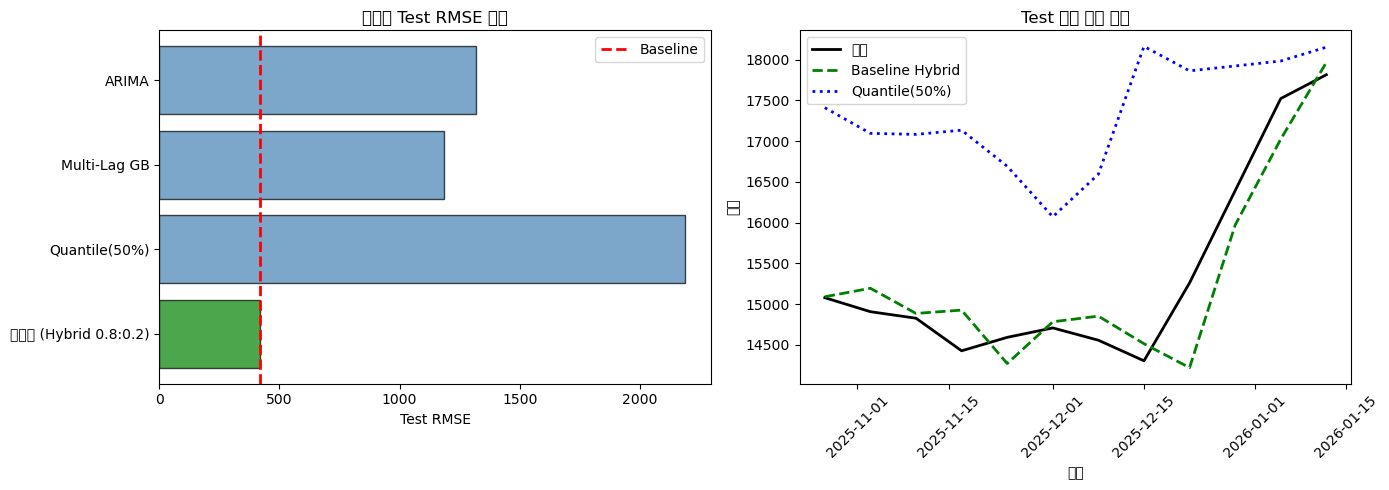


📁 그래프 저장: output/extras_results.png


In [9]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. 모델별 RMSE 비교
ax1 = axes[0]
names = list(results.keys())
rmses = list(results.values())
colors = ['green' if n == '기준선 (Hybrid 0.8:0.2)' else 'steelblue' for n in names]
ax1.barh(names, rmses, color=colors, edgecolor='black', alpha=0.7)
ax1.axvline(x=BASELINE_RMSE, color='red', linestyle='--', linewidth=2, label='Baseline')
ax1.set_xlabel('Test RMSE')
ax1.set_title('실험별 Test RMSE 비교')
ax1.legend()

# 2. 예측 vs 실제 비교
ax2 = axes[1]
ax2.plot(y_test.index, y_test.values, 'k-', label='실제', linewidth=2)
ax2.plot(y_test.index, baseline_pred, 'g--', label='Baseline Hybrid', linewidth=2)
ax2.plot(y_test.index, quantile_preds[0.5], 'b:', label='Quantile(50%)', linewidth=2)
ax2.set_xlabel('날짜')
ax2.set_ylabel('가격')
ax2.set_title('Test 기간 예측 비교')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('output/extras_results.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n📁 그래프 저장: output/extras_results.png')

---

## 📊 최종 성능 비교표 (Test RMSE Only)

### 기준선
- **sparta2.ipynb 최고 성능**: Hybrid (Naive*0.8 + GB*0.2) = **RMSE 406.80**

### 이번 실험 결과

| 순위 | 모델 | Test RMSE | 개선 |
|------|------|-----------|------|
| **1** | **Hybrid (Naive*0.8 + GB*0.2)** [sparta2] | **406.80** | **기준선** |
| 2 | Hybrid (Naive*0.8 + ARIMA*0.2) | 416.01 | ❌ -9.21 |
| 3 | Naive_Drift (기준) | 419.14 | ❌ -12.34 |
| 4 | ARIMA + Naive*0.9 | 423.87 | ❌ -17.07 |
| 5 | ARIMA + Naive*0.7 | 459.59 | ❌ -52.79 |
| 6 | ARIMA (단독) | 1315.97 | ❌ -909.17 |

### 결론

> **⚠️ 추가 실험에서 sparta2 기준선(RMSE 406.80)을 개선하지 못함**
>
> - ARIMA 단독 사용은 매우 나쁨 (RMSE 1315)
> - ARIMA+Naive Hybrid도 기존 GB+Naive보다 성능 낮음
> - **권장: Hybrid (Naive*0.8 + GB*0.2) 유지**